In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from van_code.nn import NeuralVANMultilevel_block_wise
from van_code.ising import ising_energy,analytical_solution,local_ising_energy
from van_code.montecarlo import *
from van_code.utils import *
from van_code.obs import Obs


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    default_dtype_torch=torch.float32
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = torch.device("cpu")
print(f'You are using device={device}.')

You are using device=mps.


-------------
-------------
# Model and parameters
Our multilevel architecture uses different blocks of Autoregressive neural networks which are based on the VAN architecture by [Wu et al. (2019)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.080602).

In [28]:
# This cell defines important parameters for the simulation

Lc=2 # defines the coarser lattice
beta=0.44 # defines the beta value (inverse of the temperature)

# VAN parameters
net_depth = 3
net_width= 16
half_kernel_size =6

# Conditional VAN parameters
# The i-th element of the list correspond to the parameters associated to the i-th block in the multilevel

hidden_size=[[16]] * 10 # Hidden size of each CondVAN
kernel_size=[[5,3]] * 10  # Kernel of CondVAN

nlevels = 2 # Defines the number of blocks (upsamling step) in the multilevel. Every block doubles the lattice. Example: if the coarser is 2x2 after 3 levels we have 16x16
hb_last = True # Whether to use heatbath to sample unbiased configuration from the last ARNN

pretrained = True  # Wheter to use warm-restarts in training (see paper: https://openreview.net/forum?id=YcUV5apdlq)


In [9]:
van_hyp={
    'net_depth':net_depth,
    'net_width': net_width,
    'half_kernel_size':half_kernel_size,
    'bias':False,'z2':False,
    'res_block':True,
    'x_hat_clip':False,
    'final_conv':True,
    'epsilon':1.e-8,
    'device':device
}

block_net_hyp={
    'hidden_size':hidden_size,
    'kernel_size':kernel_size,
    'epsilon':1e-7,
    'level':0,
    'device':device
}

In [10]:
# Building the model

model = NeuralVANMultilevel_block_wise(
    Lc,
    van_hyp,
    block_net_hyp,
    nlevels,
    hb_last,
    ising_energy,
    local_ising_energy,
    beta,
    device
)
Lf = model.Lf
#print(model)

print(f'\n\n=======================================================================================================================================================\n')
print(f'You will start from coarser lattices of shape {Lc}x{Lc} and sample finer lattices of resolution {model.Lf}x{model.Lf} using {nlevels} multilevel steps.')
print(f'\n=======================================================================================================================================================\n')




You will start from coarser lattices of shape 2x2 and sample finer lattices of resolution 8x8 using 2 multilevel steps.




In [11]:
# Define default parameters for optimizer and scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.92, patience=1000, min_lr=1e-07)

# Define additional training parameters. Arbitrary values can be chosen
# the values chosen below are optimized for the purpose of this demo.

bs = [16] * (nlevels+1)
nepochs = 2 * [500] * nlevels + [500]
print_freq = 10
lr = 2 * [0.001] + [0.001] * (nlevels-1)

In [12]:
# Choose main path to store model and logs
main_path=''+'../data/'

# Creates model identifier with corresponding params
# '/Lf'+'_beta'+'_nblocks'+'_PCNNdepth'+'_width'+'_half_ker'+'_CCNNhs'+'_ks'

model_id = f'{str(model.Lf)}_{str(beta)}_{str(nlevels)}_{str(net_depth)}_{str(net_width)}_{str(half_kernel_size)}_{str(hidden_size[0][0])}_{str(kernel_size[0])}'

lc_path = main_path + 'training/' + model_id
h_path = lc_path + '_history.log' # Path to Training history

## Dict of paths to store different results

res_paths = {
    'weights': main_path+ 'model/'+ model_id +'.chckpnt', # models' weights
    'sim' : main_path + 'results/' + model_id + '_measures.log',  # Simulations logging
    'sim_md' : main_path + 'results/' + model_id + '_measures_modedrop.log',  # Simulations mode dropping
    'cluster' : main_path + 'results/' + model_id + '_measuresCluster.log',  # Simulations
    'dict_hist' : lc_path + '_historyDict.pkl',  # dictionary learning curve
    'mh' : main_path+'results/'+ model_id +'_measuresIMH.log' # neural MCMC sampling results
}


-------------
-------------
# Training

In [13]:
# Load model if checkpoint exists, otherwise train a new model.

if os.path.exists(res_paths['weights']):
    print(f'\n============================================================================================================================\n')
    print(f"Loading model {res_paths['weights']}.")
    print(f'\n============================================================================================================================\n')
    load(model, optimizer, res_paths['weights'])
    with open(res_paths['dict_hist'], 'rb') as handle:
        history= pickle.load(handle)
    print(f'\n============================================================================================================================\n')
    print(f"Loading successful!")
    print(f'\n============================================================================================================================\n')

else:
    print(f'\n============================================================================================================================\n')
    print(f"Nothing to load. Training of new model... ")
    print(f'\n============================================================================================================================\n')

    history=model.train(nepochs, bs, lr, print_freq, h_path, pretrained, on_file=True)
    save(model, optimizer, res_paths['weights'])
    write(history, lc_path)

    print(f'\n============================================================================================================================\n')
    print(f"Training successful!")
    print(f'\n============================================================================================================================\n')




Nothing to load. Training of new model... 


Training VAN layers...


/Users/kimnicoli/Projects/multilevelRG/van_code/nn.py:677: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # this function will be deprecated. When this happens use function below.
/Users/kimnicoli/Projects/multilevelRG/venv/lib/python3.9/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


step: 10, loss: 0.02978837490081787, w_mean: -3.6598784923553467, w_var: 4.174248695373535, ess: 0.33485710620880127, free_en: -5.228048324584961, log_prob: -2.7798783779144287
step: 20, loss: -0.06654860079288483, w_mean: -2.7650094032287598, w_var: 1.4954653978347778, ess: 0.1503928303718567, free_en: -3.6682891845703125, log_prob: -2.7650094032287598
step: 30, loss: -0.17299821972846985, w_mean: -2.953110694885254, w_var: 2.0270965099334717, ess: 0.20657628774642944, free_en: -4.0586957931518555, log_prob: -2.7331106662750244
step: 40, loss: -0.21950280666351318, w_mean: -2.783090114593506, w_var: 2.789917230606079, ess: 0.18364550173282623, free_en: -4.12680721282959, log_prob: -2.783090114593506
step: 50, loss: -0.21467144787311554, w_mean: -3.4454731941223145, w_var: 1.4745551347732544, ess: 0.27794963121414185, free_en: -4.394181251525879, log_prob: -2.785473346710205
step: 60, loss: -0.8658982515335083, w_mean: -3.60183048248291, w_var: 2.065281391143799, ess: 0.481813192367553

step: 470, loss: 0.0025262385606765747, w_mean: -4.365150451660156, w_var: 0.013258918188512325, ess: 0.986005425453186, free_en: -4.371618270874023, log_prob: -1.5051504373550415
step: 480, loss: 0.02857578918337822, w_mean: -4.384690284729004, w_var: 0.0022644493728876114, ess: 0.9977556467056274, free_en: -4.385772705078125, log_prob: -1.0846905708312988
step: 490, loss: -0.08627751469612122, w_mean: -4.350163459777832, w_var: 0.00823912862688303, ess: 0.9933332204818726, free_en: -4.353847026824951, log_prob: -1.2701634168624878
step: 500, loss: 0.10800007730722427, w_mean: -4.375703811645508, w_var: 0.0275900699198246, ess: 0.9579075574874878, free_en: -4.391130447387695, log_prob: -1.515703558921814
Time taken for this level now 8.098997116088867
Unfreezing and training up to level 1


/Users/kimnicoli/Projects/multilevelRG/van_code/nn.py:744: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): #this function will be deprecated. If this happens use function below.
/Users/kimnicoli/Projects/multilevelRG/venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


step: 10, loss: -0.2171945571899414, w_mean: -9.679604530334473, w_var: 6.384622573852539, ess: 0.3018467128276825, free_en: -11.311588287353516, log_prob: -9.679603576660156
step: 20, loss: 0.9643186330795288, w_mean: -11.966111183166504, w_var: 5.581794738769531, ess: 0.11676358431577682, free_en: -14.182613372802734, log_prob: -10.536111831665039
step: 30, loss: -0.1812286376953125, w_mean: -12.157783508300781, w_var: 5.265305519104004, ess: 0.16017693281173706, free_en: -14.291749954223633, log_prob: -10.397784233093262
step: 40, loss: -1.105146884918213, w_mean: -11.997997283935547, w_var: 6.635134220123291, ess: 0.3451138436794281, free_en: -13.603630065917969, log_prob: -10.56799602508545
step: 50, loss: -2.881444215774536, w_mean: -12.72491455078125, w_var: 4.9507975578308105, ess: 0.1728658378124237, free_en: -15.048322677612305, log_prob: -10.084915161132812
step: 60, loss: -2.697279453277588, w_mean: -13.047880172729492, w_var: 3.9780235290527344, ess: 0.20615984499454498, f

step: 480, loss: 0.04569753259420395, w_mean: -15.47311019897461, w_var: 0.002459018724039197, ess: 0.9975711107254028, free_en: -15.474283218383789, log_prob: -2.71311092376709
step: 490, loss: -0.3331855237483978, w_mean: -15.470800399780273, w_var: 0.129622682929039, ess: 0.8567707538604736, free_en: -15.537033081054688, log_prob: -5.240799903869629
step: 500, loss: -0.09529343247413635, w_mean: -15.41141414642334, w_var: 0.0953621044754982, ess: 0.9291719198226929, free_en: -15.452919006347656, log_prob: -4.851415157318115
Time taken for this level now 22.891292333602905
Unfreezing and training up to level 2
step: 10, loss: -3.6903343200683594, w_mean: -59.8066291809082, w_var: 0.9685860276222229, ess: 0.59097820520401, free_en: -60.17267608642578, log_prob: -17.016632080078125
step: 20, loss: -2.1604385375976562, w_mean: -59.89421081542969, w_var: 0.48073554039001465, ess: 0.7805928587913513, free_en: -60.06953430175781, log_prob: -16.444210052490234
step: 30, loss: 2.186813831329

step: 440, loss: -2.9401779174804688, w_mean: -59.946929931640625, w_var: 0.19170503318309784, ess: 0.8213624954223633, free_en: -60.038291931152344, log_prob: -22.32693099975586
step: 450, loss: -0.5228137373924255, w_mean: -60.03240203857422, w_var: 0.07119623571634293, ess: 0.9310381412506104, free_en: -60.06651306152344, log_prob: -17.46240234375
step: 460, loss: -1.7770177125930786, w_mean: -59.88594436645508, w_var: 0.25966233015060425, ess: 0.8800243735313416, free_en: -59.97895812988281, log_prob: -17.425945281982422
step: 470, loss: -0.5035963654518127, w_mean: -59.92051696777344, w_var: 0.05078993737697601, ess: 0.9571030735969543, free_en: -59.943634033203125, log_prob: -13.170514106750488
step: 480, loss: -0.3617062270641327, w_mean: -60.026771545410156, w_var: 0.21773724257946014, ess: 0.8567119240760803, free_en: -60.116722106933594, log_prob: -18.446775436401367
step: 490, loss: -0.48494425415992737, w_mean: -60.12579345703125, w_var: 0.07702717930078506, ess: 0.93354183

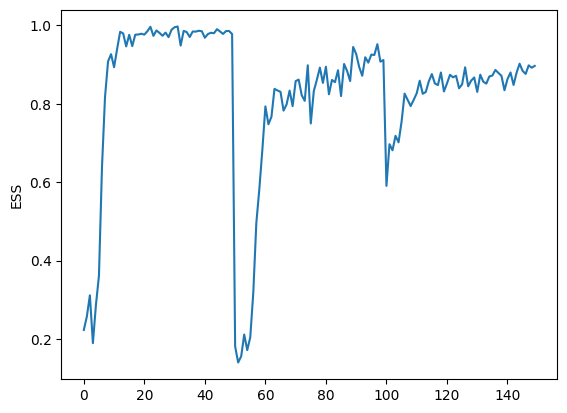

In [14]:
bins = 10 # binning to plot training history.

if history:
    plt.plot(np.asarray(history['ESS']).reshape(int((nepochs[0]*nlevels+nepochs[-1])/bins),bins).mean(-1))
    plt.ylabel('ESS')

-------------
-------------
# Analysis: Reverse Metrics
This sections includes metrics which require samples from the model, e.g., $s\sim q_\theta$ where $q_\theta$ is the autoregressive neural network.
The resulting script `res_paths['sim']` will store:

`Loss, FreeEn, ESS_rev, InternalEn, Absmag`

In [15]:
model.eval()
w,E,m,t = model.sample_n_OBS(100,1000)

In [41]:
gamma_analysis(w, res_paths['sim']) # Stores data: Loss, FreeEn, ESS_rev
_=gamma_analysis_OBS(E, w, res_paths['sim']) # Stores data: Internal Energy
_=gamma_analysis_OBS(np.abs(m), w, res_paths['sim']) # Stores data: Absolute magnetization
print(f"Results saved at: {res_paths['sim']}")

Results saved at: ../data/results/8_0.44_2_3_16_6_16_[5, 3]_measures.log


-------------
-------------
# Analysis: Forward metrics
> Note to user:
> - This only works for small lattices. As this is just a demo, configurations for larger lattices (or different $\beta$) are not provided and users have to generate reference configurations by themselves. Once configurations are available the pipeline below can be used.
> - Ensure to unzip the configurations before running the code below.


This sections includes metrics which require samples from the true distribution, e.g., $s\sim p$ where $p$ is the target Boltzmann distribution.
Such samples can be obtained with standard methods such as the Cluster method. For the sake of this demo, configs sampled with cluster method are stored in `data/config/Ising_data_nx16_beta0.4400000000_data1000000.dat`.

The script `res_paths['sim_md']` will store:

`Loss_rev, FreeEn_rev, ESS_rev, Loss_fwd, FreeEn_fwd, ESS_fwd, mode_dropping_est,  InternalEn, Absmag`

The script `res_paths['cluster']` will store analysis performed on samples from Cluster method, i.e., $s\sim p$:

`Loss, FreeEn, ESS_rev, InternalEn, Absmag`


In [31]:
ndat = 1000000
path_ising = main_path + f'config/Ising_data_nx{model.Lf}_beta0.4400000000_data{ndat}.dat'

In [32]:
# Loads data for 16x16
# N.B. This might take some time.
data = np.genfromtxt(path_ising).reshape(-1, Lf, Lf)

In [42]:
cluster_analysis(data, ising_energy, beta, res_paths['cluster']) # U, tau |m|, tau |m|
print(f"Results saved at: {res_paths['cluster']}")

Results saved at: ../data/results/8_0.44_2_3_16_6_16_[5, 3]_measuresCluster.log


In [34]:
wf = model.sample_from_MCMC(data, 1000)

In [40]:
gamma_analysis_modedrop(w, wf, res_paths['sim_md']) # Stores data: Loss, betaF, ESS, Floss, FbetaF, FESS, modedrop, U, absmag
print(f"Results saved at: {res_paths['sim_md']}")

Results saved at: ../data/results/8_0.44_2_3_16_6_16_[5, 3]_measures_modedrop.log


-------------
-------------
# Independent Metropolis-Hastings

The cells below run Neural MCMC using a Metropolis Hastings accept-reject steps to unbias the samples drawn from the model as proposed in [Nicoli et al. Phys. Rev. E (2020)](https://link.aps.org/accepted/10.1103/PhysRevE.101.023304). A cluster analysis is performed on the accepted samples and results are saved in `res_paths['mh']`.

In [19]:
model.eval()

In [20]:
ensemble=make_mcmc_ensemble(model,100, 1000,model.device)

In [45]:
print(f"Acceptance rate: {np.asarray(ensemble['accepted']).mean().item()}")

Acceptance rate: 0.792


In [43]:
 cluster_analysis(np.asarray(ensemble['x']).reshape((-1, Lf, Lf) ), model.energy, model.beta, res_paths['mh']) #U, tau |m|, tau |m|
print(f"Results saved at: {res_paths['mh']}")    

Results saved at: ../data/results/8_0.44_2_3_16_6_16_[5, 3]_measuresIMH.log
